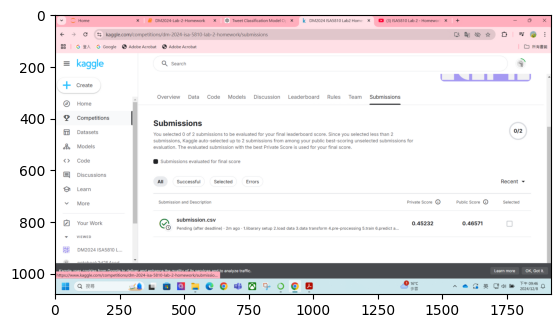

In [17]:
#Student Information
#Name:李威遠
#Student ID:113033632
#GitHub ID:Natsumedesu
#Kaggle name:Williamdesu197
#Kaggle private scoreboard snapshot:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 設定圖片路徑
img_path = 'image/pic0.png.png'

# 讀取並顯示圖片
img = mpimg.imread(img_path)
plt.imshow(img)

In [7]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [8]:
# Load data
# Load JSON file
data = []
with open('./tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

emotion = pd.read_csv('./emotion.csv')
data_identification = pd.read_csv('./data_identification.csv')


In [9]:
# Build a new dataframe by selecting useful features
df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')


In [10]:
# Filter for train data
train_data = df[df['identification'] == 'train']
train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)
# Combine text and hashtags
train_data['text'] = train_data['text'] + ' ' + train_data['hashtags'].apply(lambda x: ' '.join(x))

# Preprocess the text and labels
X = train_data['text'].values
y = train_data['emotion'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000)  # Keep top 10,000 words
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_val_pad = pad_sequences(X_val_seq, maxlen=100)


In [11]:
# Build LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train the model
history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=3, batch_size=32)


Epoch 1/3
36230/36230 ━━━━━━━━━━━━━━━━━━━━ 1073s 30ms/step - accuracy: 0.5691 - loss: 1.1955 - val_accuracy: 0.5945 - val_loss: 1.1224
Epoch 2/3
36230/36230 ━━━━━━━━━━━━━━━━━━━━ 1104s 30ms/step - accuracy: 0.6052 - loss: 1.0967 - val_accuracy: 0.6010 - val_loss: 1.1043
Epoch 3/3
36230/36230 ━━━━━━━━━━━━━━━━━━━━ 1118s 31ms/step - accuracy: 0.6211 - loss: 1.0523 - val_accuracy: 0.6044 - val_loss: 1.0978


In [14]:
# Prepare test data
test_data = df[df['identification'] == 'test']
test_data['text'] = test_data['text'] + ' ' + test_data['hashtags'].apply(lambda x: ' '.join(x))
X_test = test_data['text'].values
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Predict emotions for test data
y_test_pred = model.predict(X_test_pad)
y_test_labels = le.inverse_transform(np.argmax(y_test_pred, axis=1))

# Make up submit format
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_test_labels
})
submission.to_csv('./submission.csv', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_14412\245456104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['text'] = test_data['text'] + ' ' + test_data['hashtags'].apply(lambda x: ' '.join(x))


12875/12875 ━━━━━━━━━━━━━━━━━━━━ 118s 9ms/step
